BACKTRADER TUTORIAL

Installing Backtrader and yfinance Library

In [1]:
!pip install backtrader
!pip install yfinance

Importing the necessary packages

In [2]:
import backtrader as bt
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
import backtrader.strategies as btstrats
import backtrader.indicators
import datetime
import yfinance as yf
import matplotlib as plt

Creating a Strategy Class

Strategy:
Go Long when ever a fast sma crosses slow sma and close the position when the slow sma crosses fast sma

In [3]:
class SMAC(bt.Strategy):

    # Creating Parameters to customize the strategy
    params = (('sma_fast', 14), ('sma_slow', 50)) # Lookback Period for the SMA's

    def __init__(self):
        self.order = None
        self.closepos = None
        self.sma1 = bt.indicators.SMA(self.data.close, period=self.params.sma_fast)  # Initialise the faster EMA
        self.sma2 = bt.indicators.SMA(self.data.close, period=self.params.sma_slow)  # Initialise the slower EMA
        self.crossover = bt.ind.CrossOver(self.sma1, self.sma2) # crossover signal - fast sma moves above slow sma

    def log(self, txt, doprint=True): # Function to print out log details
        date = self.data.datetime.date(0)
        time = self.data.datetime.time(0)
        if doprint:
            print(str(date) + '--' + txt)


    def notify_order(self, order): # Function to notify when a new order is being executed or cancelled
        if order.status in [order.Submitted, order.Accepted]: # To check if an order has been completed
            return
        elif order.status == order.Completed: # To notify placed orders
            if order.isbuy(): # To notify buy
                self.log('BUY   price: {}, value: {}, commission: {}'.format(order.executed.price, order.executed.value, order.executed.comm))
            if order.issell(): # To notify sell
                self.log('SELL   price: {}, value: {}, commission: {}'.format(order.executed.price, order.executed.value, order.executed.comm))
        elif order.status in [order.Rejected, order.Margin]: # To notify cancelled orders
            self.log('Order Rejected/Margin')

        self.order = None # to write down no pending order


    def notify_trade(self, trade): # Funtion to notify about pnl after closing a trade
        if trade.isclosed:
            self.log('CLOSE   Gross P/L: {}, Net P/L: {}'.format(trade.pnl, trade.pnlcomm))


    def next(self): # Function which contains the strategy in it

        if self.position.size == 0: # If we are not in any position
                if (self.crossover > 0): # Condition to enter Long
                    self.order = self.buy() # Place buy order

        if self.position.size > 0: # If we are in a long position
            if (self.crossover < 0): # Condition to close open long positions
                self.closepos = self.close() # Closing our buy position

In [4]:
class EMA_RSI(bt.Strategy):

    params = (('EMA_F', 9), ('EMA_S', 26), ('RSI', 14)) # Lookback Period for EMA and RSI

    ''' Create 3 parameters EMA_F, EMA_S, RSI and set their values to 9, 26, 14 '''



    def __init__(self):
        self.order = None
        self.stopprice = None
        self.closepos = None
        self.emaf = bt.indicators.EMA(self.data.close, period=self.params.EMA_F)  # Initialise the faster EMA
        self.emas = bt.indicators.EMA(self.data.close, period=self.params.EMA_S)  # Initialise the slower EMA
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=self.params.RSI) # Initialise RSI


    def log(self, txt, doprint=True):
        date = self.data.datetime.date(0)
        time = self.data.datetime.time(0)
        if doprint:
            print(str(date) + '--' + txt)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        elif order.status == order.Completed:
            if order.isbuy():
                self.log('BUY   price: {}, value: {}, commission: {}'.format(order.executed.price, order.executed.value, order.executed.comm))
            if order.issell():
                self.log('SELL   price: {}, value: {}, commission: {}'.format(order.executed.price, order.executed.value, order.executed.comm))
        elif order.status in [order.Rejected, order.Margin]:
            self.log('Order Rejected/Margin')

        self.order = None


    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('CLOSE   Gross P/L: {}, Net P/L: {}'.format(trade.pnl, trade.pnlcomm))


    def next(self):
        if self.order:
            return

        if self.position.size == 0:
            # Place order for SELL if fast ema is less than slow ema and rsi is greater than 70
            if self.emaf[0] < self.emas[0] and self.rsi[0] > 70:
                self.sell()

            # Place order for BUY if fast ema is greater than slow ema and rsi is less than 30
            elif self.emaf[0] > self.emas[0] and self.rsi[0] < 30:
                self.buy()

        elif self.position.size > 0:
            # Close LONG position if close is greater than or equal to fast ema and rsi is greater than 70
            if self.data.close[0] >= self.emaf[0] and self.rsi[0] > 70:
                self.close()

        elif self.position.size < 0:
            # Close SHORT position if close is less than or equal to fast ema and rsi is less than 30
            if self.data.close[0] <= self.emas[0] and self.rsi[0] < 30:
                self.close()


Adding a Data Feed.
Setting the Cash, along with commission to be given



In [7]:
cerebro = bt.Cerebro() # Instantiating the cerebro engine
from kite_trade import *
import pandas as pd
enctoken = "rBe/6uGyeWBzsnYsUsNPCZktdlsQWI3wr/6DLfLahUbwu64ZY5QH/AGpqGK4sO9QU1L/SVAR2DUDg2ZI9nHKFmGnfEuDrD3dJihxNRLCuTIs8Y9EfsR+dw=="
kite = KiteApp(enctoken=enctoken)
datapath = 'TITAN.NS.csv' # To set a sub-folder from where data feed will be collected
feed = pd.DataFrame(kite.historical_data('519937', '2023-06-29', '2023-06-30', 'minute', continuous=False, oi=False))
cerebro.adddata(feed) # To feed the data into Cerebro engine

cerebro.addstrategy(EMA_RSI) # To add the strategy
cerebro.broker.setcash(100000.0) # To set initial portfolio value
cerebro.broker.setcommission(commission=.0002) # To set broker commission

cerebro.addsizer(bt.sizers.PercentSizer, percents=90) # To allocate percentage of portfolio to execute an order

AttributeError: 'DataFrame' object has no attribute 'setenvironment'

In [ ]:
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")

Printing trade logs

In [ ]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue()) # Print the initial portfolio value
backtest_result = cerebro.run() # Setting cerebro to run (loop over the data)
backtest_result_1 = backtest_result[0]
final = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % final) # Print the final portfolio value
print('Sharpe Ratio:', backtest_result_1.analyzers.mysharpe.get_analysis()) # Print the Sharpe ratio

Starting Portfolio Value: 100000.00
2020-09-02--BUY   price: 915.0, value: 90083.68189103689, commission: 18.01673637820738
2020-09-18--SELL   price: 1011.0, value: 90083.68189103689, commission: 19.90701691624881
2020-09-18--CLOSE   Gross P/L: 9451.40269020715, Net P/L: 9413.478936912694
2020-11-03--BUY   price: 1072.0, value: 98444.57677093096, commission: 19.688915354186193
2020-12-21--SELL   price: 1188.0, value: 98444.57677093096, commission: 21.819432314154103
2020-12-21--CLOSE   Gross P/L: 10652.584799839544, Net P/L: 10611.076452171204
2021-02-02--BUY   price: 1280.0, value: 109658.40679753943, commission: 21.931681359507888
2021-03-16--SELL   price: 1386.050048828125, value: 109658.40679753943, commission: 23.74875626502249
2021-03-16--CLOSE   Gross P/L: 9085.374527573009, Net P/L: 9039.694089948478
2022-07-07--SELL   price: 1503.050048828125, value: -117045.56764369969, commission: 23.409113528739937
2022-08-30--BUY   price: 1473.0999755859375, value: -117045.56764369969, com

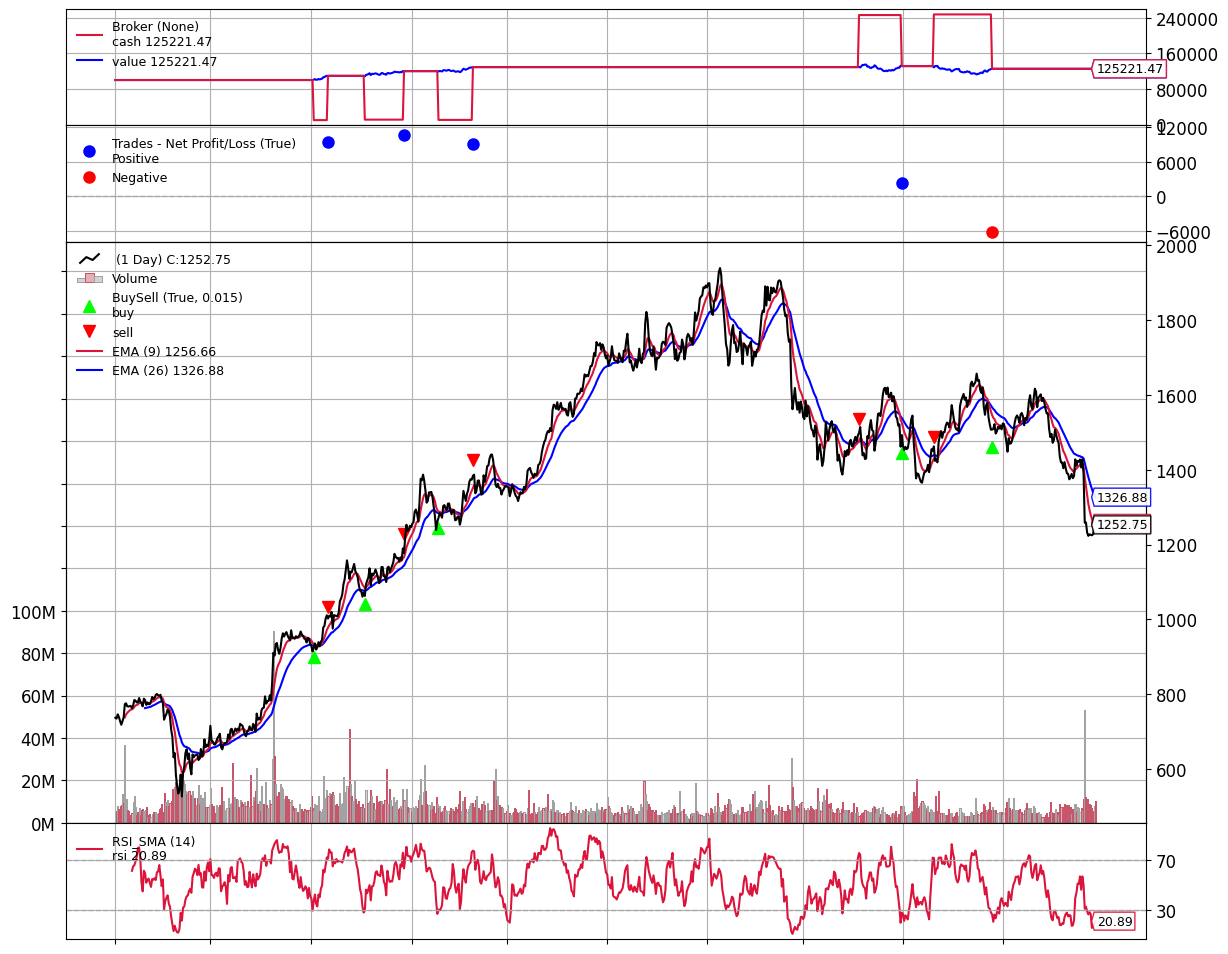

[[<Figure size 1200x1000 with 5 Axes>]]

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams.update({'font.size': 12})
cerebro.plot(iplot = False) # To plot the result